In [1]:
import cv2
import numpy as np

import glob

import time

import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import os
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8 
cell_per_block=2 
hog_channel=0
                     
spatial_feat=True
hist_feat=True
hog_feat=True

In [3]:
# load the dataset
# path_dataset_vehicle = ./dataset/vehicles
# path_dataset_nonvehicle = ./dataset/non-vehicles

# vehicles

veh_gti_far = glob.glob('./dataset/vehicles/GTI_Far/*.png')
veh_gti_l = glob.glob('./dataset/vehicles/GTI_Left/*.png')
veh_gti_mid_close = glob.glob('./dataset/vehicles/GTI_MiddleClose/*.png')
veh_gti_r = glob.glob('./dataset/vehicles/GTI_Right/*.png')
veh_kitti = glob.glob('./dataset/vehicles/KITTI_extracted/*.png')

#non vehicles
nonveh_extras = glob.glob('./dataset/non-vehicles/Extras/*.png')
nonveh_gti = glob.glob('./dataset/non-vehicles/GTI/*.png')

# evaluate the dataset
len_veh_gti_far = len(veh_gti_far)
len_veh_gti_l = len(veh_gti_l)
len_veh_gti_mid_close = len(veh_gti_mid_close)
len_veh_gti_r = len(veh_gti_r)
len_veh_kitti = len(veh_kitti)
len_all_veh = len_veh_gti_far + len_veh_gti_l + len_veh_gti_mid_close \
    + len_veh_gti_r + len_veh_kitti


len_nonveh_extras = len(nonveh_extras)
len_nonveh_gti = len(nonveh_gti)
len_all_non_veh =len_nonveh_extras+len_nonveh_gti

print('veh_gti_far length: {}' .format(len_veh_gti_far))
print('veh_gti_l length: {}' .format(len_veh_gti_l))
print('veh_gti_far length: {}' .format(len_veh_gti_mid_close))
print('veh_gti_far length: {}' .format(len_veh_gti_r))
print('veh_gti_far length: {}' .format(len_veh_kitti))
print('nonveh_extras length: {}' .format(len_nonveh_extras))
print('nonveh_gti length: {}' .format(len_nonveh_gti))

print('Total Vehicles: {} Total Non Vehicles: {}' .format(len_all_veh,len_all_non_veh ))

veh_gti_far length: 834
veh_gti_l length: 909
veh_gti_far length: 419
veh_gti_far length: 664
veh_gti_far length: 5966
nonveh_extras length: 5068
nonveh_gti length: 3900
Total Vehicles: 8792 Total Non Vehicles: 8968


In [4]:
# shuffle and split the data 
all_veh = veh_gti_far + veh_gti_l + veh_gti_mid_close \
    + veh_gti_r + veh_kitti

all_non_veh = nonveh_extras + nonveh_gti

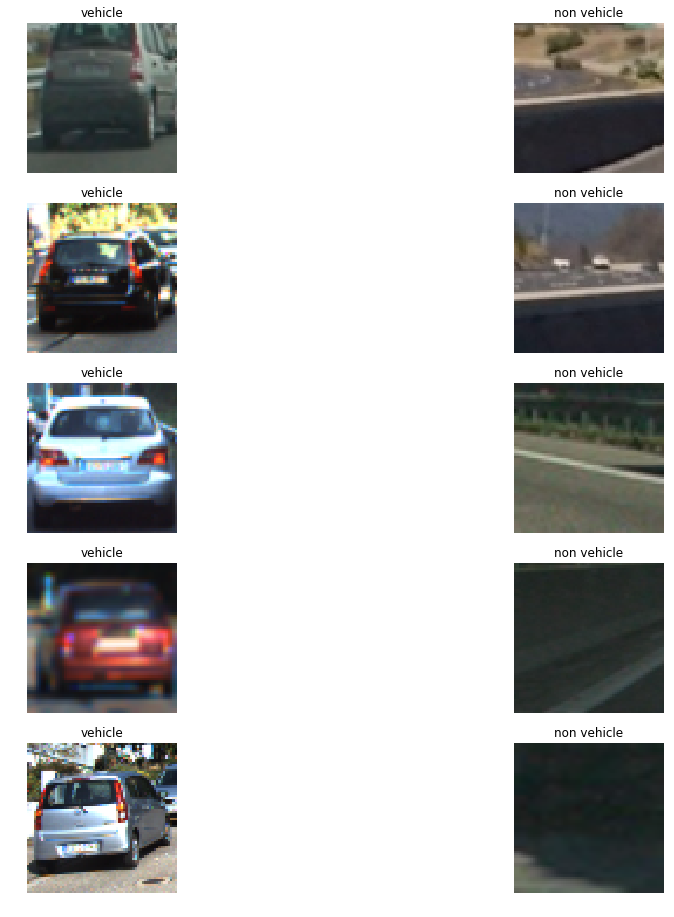

In [5]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = (20,20)
# plt.rcParams['figure.figsize'] = (10.0, 8.0)
# matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#print ('rows: {}' .format(rows))

n_examples = 5
columns = 2
w = 16
h = 16
# fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(n_examples,columns, figsize=(w,h))
axes = axes.ravel()
for i in range(len(axes)):
    axes[i].axis('off')
    
# iterate through the classes and pull together useful information
for i in range(n_examples): 
    axes[i * 2].imshow(mpimg.imread(all_veh[np.random.randint(0,len(all_veh)-1)]))
    axes[i * 2].set_title('vehicle')
    axes[i * 2 +1].imshow(mpimg.imread(all_non_veh[np.random.randint(0,len(all_non_veh)-1)]))
    axes[i * 2 +1].set_title('non vehicle')

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=False, feature_vector=feature_vec)
        return features

In [7]:
def plot_figure(array_to_plot, labels_array, n_rows, n_columns, figuresize=(64,64),colourmap='gray'):
    fig, axes = plt.subplots( n_rows, n_columns,figsize=figuresize)
    axes = axes.ravel()

    for i in range(len(array_to_plot)):
        print('i {}'.format(i))
        print('title {}'.format(labels_array[i]))
        axes[i].imshow(array_to_plot[i], cmap=colourmap)
        axes[i].set_title(labels_array[i])
        axes[i].axis('off')

    # TODO Reinstate
    plt.tight_layout()
    plt.show()
    plt.savefig('./output_images/dataset_samples.png')

In [8]:
def explore_hog(veh_img,gray):

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (20,20)
    
    print ('function to visualise the dataset and hog output')

    i=0
    rows = 2
    columns = 4
    w = 16
    h = 16
    
    # fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
    fig, axes = plt.subplots(rows,columns, figsize=(w,h))
    plt.tight_layout()
    fig.subplots_adjust(hspace = .1, wspace=.5)    
    
    axes = axes.ravel()
    # for i in range(len(axes)):
    #     axes[i].axis('off')
        
    # iterate through the classes and pull together useful information
    # for i in range(n_examples): 
    # veh_img = mpimg.imread(all_veh[rnd])
    axes[i*0].set_title('vehicle')   
    axes[i*0].imshow(veh_img)

    axes[i*4+1].set_title('chn0')     
    axes[i*4+1].imshow(veh_img[:,:,0], cmap='gray')
    axes[i*4+2].set_title('chn1')
    axes[i*4+2].imshow(veh_img[:,:,1], cmap='gray')
    axes[i*4+3].set_title('chn2')     
    axes[i*4+3].imshow(veh_img[:,:,2], cmap='gray')
       

    
    i+=1
    features, hog_image = get_hog_features(gray, orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4].set_title('gray')    
    axes[i*4].imshow(hog_image, cmap='gray')
    
    features, hog_image = get_hog_features(veh_img[:,:,0], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+1].set_title('chn0')    
    axes[i*4+1].imshow(hog_image, cmap='gray')
      
    features, hog_image = get_hog_features(veh_img[:,:,1], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+2].set_title('chn1')    
    axes[i*4+2].imshow(hog_image, cmap='gray')

    features, hog_image = get_hog_features(veh_img[:,:,2], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+3].set_title('chn2')    
    axes[i*4+3].imshow(hog_image, cmap='gray')

In [9]:
def convert_color(img, cspace='YCrCb'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'LAB':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LAB) 
    else: 
        return np.copy(img)

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [11]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_from_course(files, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in files:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(img, cspace)

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


def extract_imgs_features(files, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True): 
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in files:
        img = mpimg.imread(file)
        # plt.imshow(img)
        flip = False
        if flip:
            newfeatures, rev_newfeatures = single_img_features_with_flip(img, cspace=cspace, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True)
            features.append(newfeatures)
            features.append(rev_newfeatures)
            
        else:
            features.append(single_img_features(img, cspace=cspace, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True))
    return features

In [13]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hog_feat=True, hist_feat=False):    
    #1) Define an empty list to receive features
    img_features = []
    
    # print('image shape: {}' .format(img.shape))
    
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, cspace)   
  
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        # print('hog_feat')
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                # print('Using ALL channels'.format(hog_channel))
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            # print('Using single channel: {}'.format(hog_channel))
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        # print('img_features len: {}' .format(len(img_features)))

    #9) Return concatenated array of features
    return np.concatenate(img_features)

print('end of cell')

end of cell


In [14]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features_with_flip(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hog_feat=True, hist_feat=False):
    #1) Define an empty list to receive features
    img_features = []
    rev_img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, cspace)        
    
    reversed_image =np.copy(cv2.flip(feature_image, 1 ))
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            rev_hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  

                rev_hog_features.extend(get_hog_features(reversed_image[:,:,channel], 
                    orient, pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True)) 
                
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            rev_hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        rev_img_features.append(rev_hog_features)     

        # print('img_features len: {}' .format(len(img_features)))

    #9) Return concatenated array of features
    return np.concatenate(img_features),  np.concatenate(rev_img_features)

In [15]:
def split_dataset(X, y):
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    # X_train, X_test, y_train, y_test = train_test_split(
    #     scaled_X, y, test_size=0.2, random_state=rand_state)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    
    print('X_train len: {}' .format(len(X_train)))
    print('X_train len: {}' .format(len(y_train)))
    print('X_test len: {}' .format(len(X_test)))
    print('y_test len: {}' .format(len(y_test)))
    # 
    return X_train, X_test, y_train, y_test

In [16]:
def get_features(cspace, hog_channel ):
    # print('extracting features')
    car_features = extract_imgs_features(cars, cspace=cspace, spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                            spatial_feat=False, hist_feat=False, hog_feat=True)
    notcar_features = extract_imgs_features(notcars, cspace=cspace, spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                            spatial_feat=False, hist_feat=False, hog_feat=True)
    print('done extracting features')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    print ('car_features len: {}, notcar_features' .format(len(notcar_features)))
    return X, y

In [17]:
def train_svc(X_train, y_train, X_test, y_test, svc):

    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    train_time = round(t2-t, 2)
    print(train_time, 'Seconds to train SVC...')
    # Check the score of the SVC
    acc =  round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    return svc, acc, train_time

In [18]:
def predict_svn(X_test, y_test, svc):
    n_predict = 10
    t=time.time()
    print('My SVC predicts: \t', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: \t', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc

In [19]:
def train_predict(cspace, hog_channel, svc):
    
    print('-----------------------------------------------------------')
    msg = ('Colourspace: {}, hog channel: {}' .format(cspace, hog_channel))
    print(msg)
    X, y = get_features(cspace, hog_channel )
    X_train, X_test, y_train, y_test = split_dataset(X,y)
    
    # Use a linear SVC 
    # print('creating svc')
    # svc = LinearSVC()
    # print('done creating svc')
    svc, acc,train_time = train_svc(X_train, y_train, X_test, y_test, svc)
    svc = predict_svn(X_test, y_test, svc)
    msg = msg + '- \taccuracy: {}' .format(acc) + '\ttrain time: {}' .format(train_time)
    print(msg)
    return svc, X, y
    print('-----------------------------------------------------------')

In [20]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

print('running')
cars = all_veh
notcars = all_non_veh


global_colour_space = 'HLS'
global_channel = 'ALL'
X = None
y = None

# train_predict('YCrCb', 'ALL')
svc = LinearSVC()
sandbox = False
if sandbox:
    cspaces =  ['RGB', 'HLS', 'HSV', 'YUV', 'LUV', 'YCrCb', 'LAB']
    channels =  ['ALL', 0, 1,2]

    for cspace in cspaces:
        for channel in channels:
        # call the svn
            svc, X, y = train_predict(cspace, channel, svc) 
else:
    svc, X, y = train_predict(global_colour_space, global_channel, svc) 
 
print('done')

running
-----------------------------------------------------------
Colourspace: HLS, hog channel: ALL


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


done extracting features
car_features len: 8968, notcar_features
X_train len: 14208
X_train len: 14208
X_test len: 3552
y_test len: 3552
7.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9842
My SVC predicts: 	 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels: 	 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
0.00149 Seconds to predict 10 labels with SVC
Colourspace: HLS, hog channel: ALL- 	accuracy: 0.9842	train time: 7.9
done


In [21]:
# svc = train_svc(X_train, y_train)

In [22]:
# n_predict = 10
# print('My SVC predicts: \t', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: \t', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [23]:
def save_model(filename):
    with open(filename, 'wb') as save_file:
        pickle.dump(
            {   'svc':svc, 
                # 'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,       
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
            },
            save_file, pickle.HIGHEST_PROTOCOL)

In [24]:
save_model('svc_pickle.p')

In [25]:
# Start of the sliding window functioality

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [26]:
#load data from files

dist_pickle = pickle.load( open("./svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

In [27]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [28]:
# extracted the code to get the searchable portion of the image into its own meth
def get_image_to_search(full_img, ystart, ystop):
    img_tosearch = full_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace='RGB2YCrCb')
    # plt.imshow(ctrans_tosearch)
    return ctrans_tosearch

image shape: (720, 1280, 3)


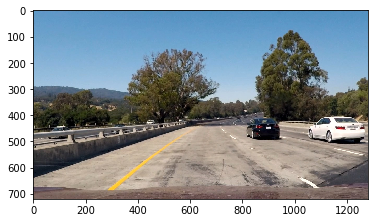

In [29]:
# 

img = mpimg.imread('./test_images/test1.jpg')
plt.imshow(img)
print('image shape: {}'.format(img.shape))
    
# ystart = 400
# ystop = 656
# scale = 1.5
# ctrans_tosearch = get_image_to_search(img, ystart, ystop)

In [30]:
class Rect():
    def __init__(self, xbox_left, ytop_draw, win_draw):
        self.image_raw = False
        self.xbox_left = xbox_left
        self.ytop_draw = ytop_draw
        self.win_draw = win_draw
        # create a box variable in the format the heat map expects
        self.box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    

    posi_boxes = []
    negi_boxes = []
    
    # print('image shape: {}'.format(img.shape))
    
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # 
    # ctrans_tosearch = get_image_to_search(img, ystart, ystop)
    # print('image shape: {}'.format(ctrans_tosearch.shape))
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=global_colour_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # print('nblocks_per_window: {}' .format(nblocks_per_window))
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if (global_channel == 0):
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif (global_channel == 1):
                hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif (global_channel == 2):
                hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif(global_channel == 'ALL'):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()            
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
          
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = svc.predict(hog_features.reshape(1, -1))    
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            if test_prediction == 1:
                # xbox_left = np.int(xleft*scale)
                # ytop_draw = np.int(ytop*scale)
                # win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                # rect = Rect(xbox_left, ytop_draw, win_draw)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                posi_boxes.append(box)
            else:
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                negi_boxes.append(box)
                
    for box in negi_boxes:
        # xbox_left = rect.xbox_left
        # ytop_draw = rect.ytop_draw
        # win_draw = rect.win_draw
        # cv2.rectangle(draw_img ,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)            
        cv2.rectangle(draw_img ,box[0],box[1],(0,0,255),6)                                    
    
    for box in posi_boxes:
        # xbox_left = rect.xbox_left
        # ytop_draw = rect.ytop_draw
        # win_draw = rect.win_draw
        # cv2.rectangle(draw_img ,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6)            
        cv2.rectangle(draw_img ,box[0],box[1],(255,0,0),6)       
                
    return draw_img, posi_boxes, negi_boxes

In [ ]:
# get the boxes for the found cars in an image
def get_boxes_from_image(img):
    ystart = 400
    ystop = 580
    scale = 1
    out_img_1, posi_boxes_1, neg_boxes_1 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 656    
    scale = 1.5
    out_img_15, posi_boxes_15, neg_boxes_15 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 2
    out_img_2, posi_boxes_2, neg_boxes_2 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 3
    out_img_3, posi_boxes_3, neg_boxes_3 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 380
    ystop = 656
    scale = 4
    out_img_4, posi_boxes_4, neg_boxes_4 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


    all_posi_boxes =  posi_boxes_1 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4
    return all_posi_boxes, out_img_1, out_img_2, out_img_3, out_img_4

In [ ]:
# ystart = 400
# ystop = 560
# scale = 1
# out_img_1, posi_boxes_1, negi_boxes_1 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# ystart = 400
# ystop = 656
# scale = 1.5
# out_img_15, posi_boxes_15, neg_boxes_15 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# ystart = 400
# ystop = 656
# scale = 2
# out_img_2, posi_boxes_2, neg_boxes_2 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# ystart = 400
# ystop = 656
# scale = 3
# out_img_3, posi_boxes_3, neg_boxes_3 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# scale = 4
# ystart = 360
# ystop = 656
# out_img_4, posi_boxes_4, neg_boxes_3 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

all_posi_boxes, out_img_1, out_img_2, out_img_3, out_img_4 = get_boxes_from_image(img)
# plt.imshow(out_img)

fig = plt.figure()
fig.set_figheight(32)
fig.set_figwidth(32)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplot(611)
plt.imshow(img)
plt.title('Input Image')
plt.subplot(612)
plt.imshow(out_img_1)
plt.title('Windows-Scale 1')
plt.subplot(613)
plt.imshow(out_img_15)
plt.title('Windows-Scale 1.5')
plt.subplot(614)
plt.imshow(out_img_2)
plt.title('Windows-Scale 2')
plt.subplot(615)
plt.imshow(out_img_3)
plt.title('Windows-Scale 3')
plt.subplot(616)
plt.imshow(out_img_4)
plt.title('Windows-Scale 4')

# fig.tight_layout()
plt.savefig('./output_images/windows_all.png',bbox_inches='tight')

In [32]:
all_posi_rec =  posi_boxes_1 + posi_boxes_15 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4

In [33]:
filename = 'bbox_pickle.p'
with open(filename, 'wb') as save_file:
    pickle.dump( all_posi_rec, open( filename, "wb" ) )

In [34]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
all_posi_boxes = pickle.load( open( "bbox_pickle.p", "rb" ))

# # Read in image similar to one shown above 
# image = mpimg.imread('test_image.jpg')
# heat = np.zeros_like(image[:,:,0]).astype(np.float)

In [35]:
def add_heat(heatmap, boxes):
    # Iterate through list of bboxes
    for box in boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [36]:
# apply a threshold to heatmap. Anything less that the threshold is discarded.
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [37]:
# draw bounding box using the max and min of the labels
#the labels were created from the heatmaps
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    # print('labels count')
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

video: False


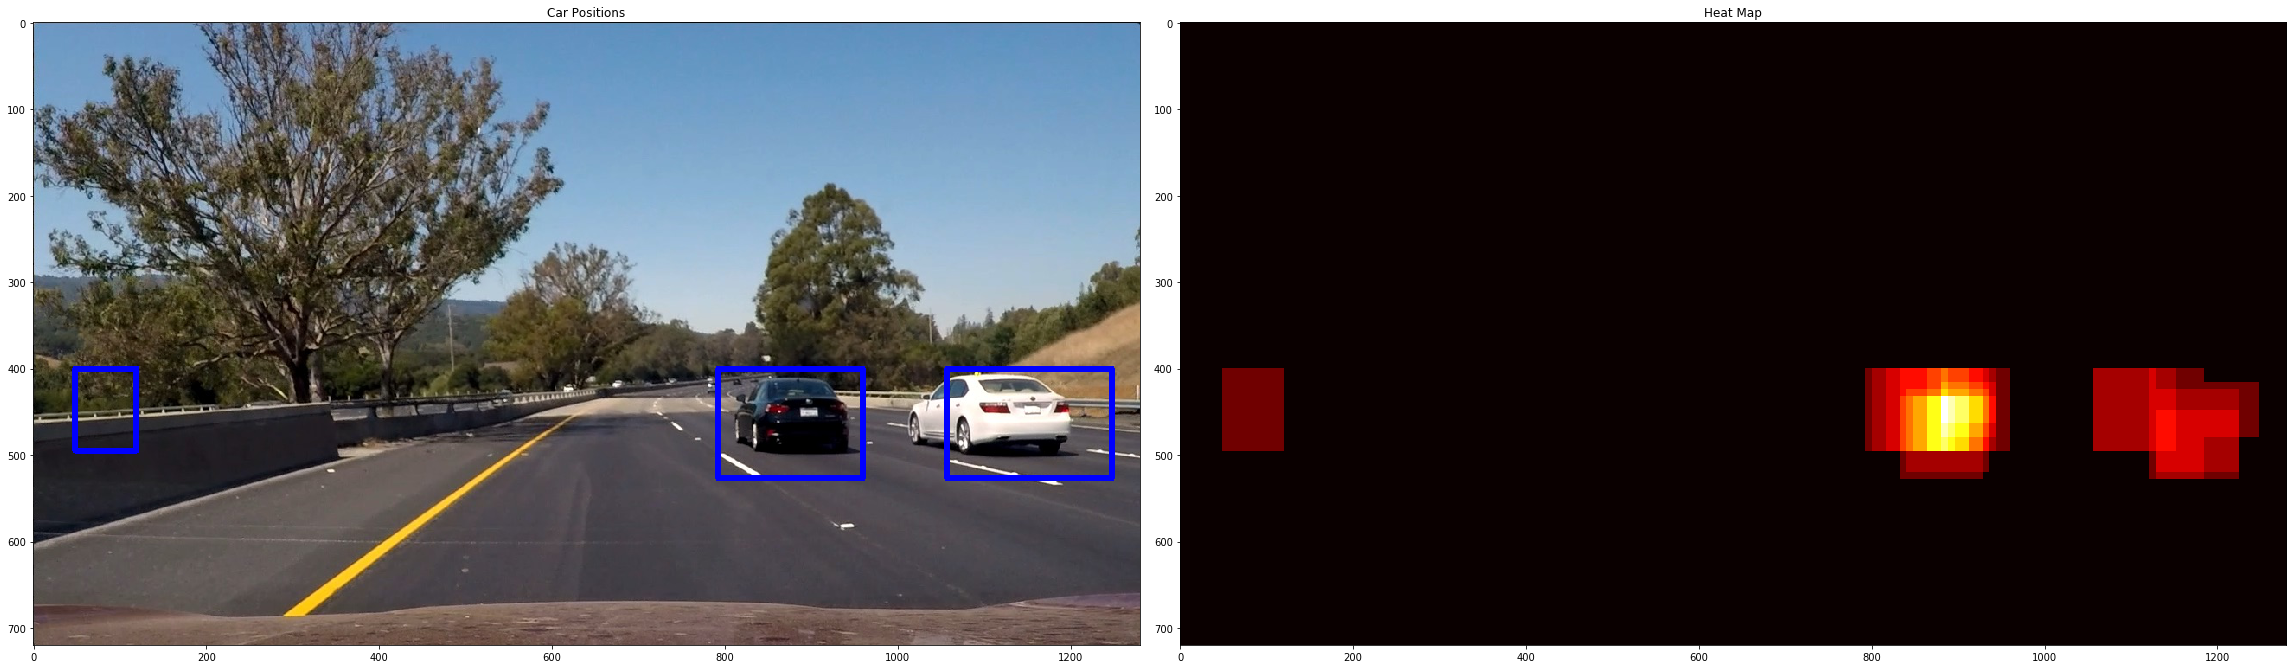

In [45]:
# get the bounding boxes of each car by creating heat maps and thresholding
def get_bb_via_heat(img, boxes, video=False):
#     print('boxes : {}' .format((boxes)))
    heat = np.zeros_like(np.copy(img[:,:,0]))
    threshold = 1    
    
    print('video: {}'.format(video))
    if video == True:
        threshold = 5
        no_of_frames_to_avg = 10
        current_frame_boxes = list(boxes)
        
        recent_frame_boxes.append(current_frame_boxes)
#         print('recent_frame_boxes len: {}' .format(len(recent_frame_boxes)))
#         print('recent_frame_boxes shape: {}' .format((recent_frame_boxes.shape)))
        if (len(recent_frame_boxes) > no_of_frames_to_avg) :
            del recent_frame_boxes[0]

        boxes = []
        for frame_boxes in recent_frame_boxes: 
            boxes = boxes + frame_boxes
#         print('boxes : {}' .format((boxes)))
#         print('boxes len: {}' .format(len(boxes)))
#         heat = add_heat(heat, boxes)
    # Add heat to each box in box list

    heat = add_heat(heat, boxes)

        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap


draw_img, heatmap = get_bb_via_heat(img, all_posi_boxes)    
recent_frame_boxes = []
fig = plt.figure()
fig.set_figheight(32)
fig.set_figwidth(32)
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('./output_images/heatmap.png',bbox_inches='tight')

In [39]:
# def get_boxes_from_image():
#     ystart = 400
#     ystop = 580
#     scale = 1
#     out_img_1, posi_boxes_1, neg_boxes_1 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     ystart = 400
#     ystop = 656    
#     scale = 1.5
#     out_img_15, posi_boxes_15, neg_boxes_15 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     
#     scale = 2
#     out_img_2, posi_boxes_2, neg_boxes_2 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
#     scale = 3
#     out_img_3, posi_boxes_3, neg_boxes_3 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     ystart = 380
#     ystop = 656
#     scale = 4
#     out_img_4, posi_boxes_3, neg_boxes_4 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# 
#     all_posi_boxes =  posi_boxes_1 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4
#     return all_posi_boxes

In [40]:
# method to process an image 
def process_image(img):
    all_posi_boxes = get_boxes_from_image(img)
    # all_posi_boxes =  posi_boxes_1 + posi_boxes_15 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4
    draw_img, heatmap = get_bb_via_heat(img, all_posi_boxes, False) 

    return draw_img

In [41]:
def process_image_video(img):
    all_posi_boxes = get_boxes_from_image(img)
    # all_posi_boxes =  posi_boxes_1 + posi_boxes_15 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4
    draw_img, heatmap = get_bb_via_heat(img, all_posi_boxes, True) 

    return draw_img

processing file: ./test_images\test1.jpg


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


processing file: ./test_images\test2.jpg
processing file: ./test_images\test3.jpg
processing file: ./test_images\test4.jpg
processing file: ./test_images\test5.jpg
processing file: ./test_images\test6.jpg


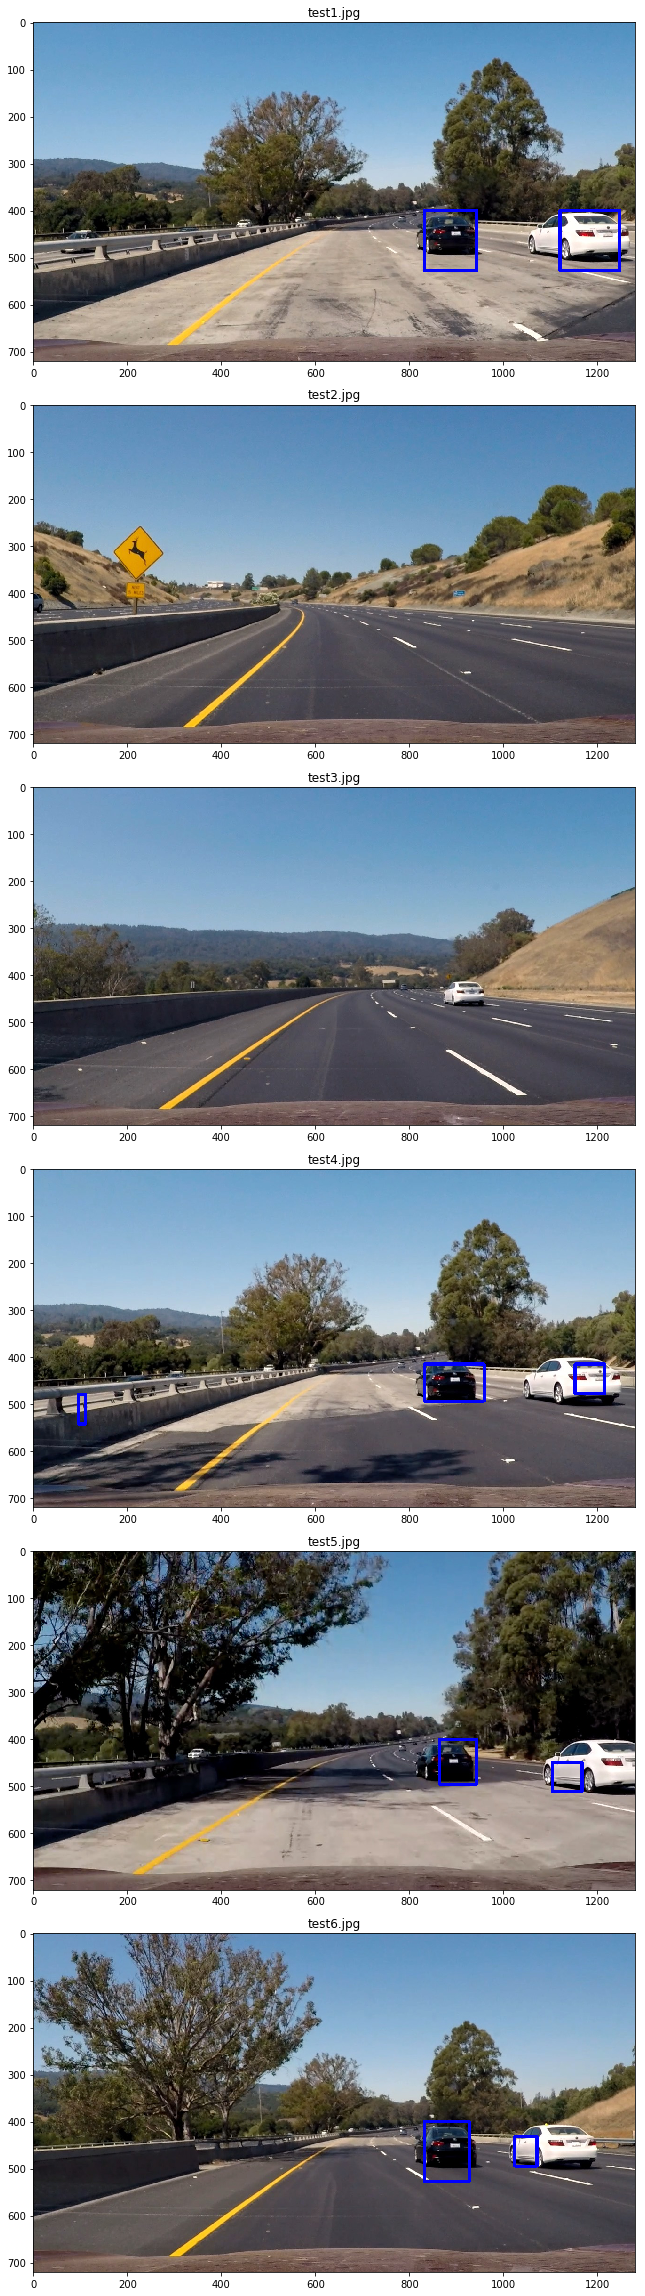

In [42]:
# parse the test images and call the process image method
test_image_files = glob.glob('./test_images/*.jpg')
processed_imgs = []
num_imgs =  len(test_image_files)
fig = plt.figure()
subplot_ind = 11 + num_imgs * 100
fig.set_figheight(32)
fig.set_figwidth(32)

for file in test_image_files:
    print ('processing file: {}' .format(file))
#     print(os.path.basename(file))
    # processed_imgs.append(process_image(img))
    img = mpimg.imread(file)
    plt.subplot(subplot_ind)
    plt.title(os.path.basename(file))
    processed_img = process_image(img)
    plt.imshow(processed_img)


    subplot_ind += 1

fig.tight_layout()

plt.savefig('./output_images/test_images_output.png',bbox_inches='tight')

In [ ]:
# process a video, which in turn call the process_image method
from moviepy.editor import VideoFileClip
from IPython.display import HTML

recent_frame_boxes = []

def process_video(input_video_filename, output_video_filename):
#     output_video = 'output.mp4'
    clip1 = VideoFileClip(input_video_filename)


    output_clip = clip1.fl_image(process_image_video)
    output_clip.write_videofile(output_video_filename, audio=False)

# process_image(image)


output_video_filename = 'project_video_output.mp4'
# input_video_filename = 'test_video.mp4'
# input_video_filename = 'project_video.mp4'
input_video_filename = 'challenge_video.mp4'

process_video(input_video_filename, output_video_filename)

video: True
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



  0%|          | 0/485 [00:00<?, ?it/s]

video: True



  0%|          | 1/485 [00:00<05:07,  1.57it/s]

video: True



  0%|          | 2/485 [00:01<05:11,  1.55it/s]

video: True



  1%|          | 3/485 [00:01<05:14,  1.53it/s]

video: True



  1%|          | 4/485 [00:02<05:18,  1.51it/s]

video: True



  1%|          | 5/485 [00:03<05:16,  1.52it/s]

video: True



  1%|          | 6/485 [00:03<05:15,  1.52it/s]

video: True



  1%|▏         | 7/485 [00:04<05:18,  1.50it/s]

video: True



  2%|▏         | 8/485 [00:05<05:17,  1.50it/s]

video: True



  2%|▏         | 9/485 [00:05<05:15,  1.51it/s]

video: True



  2%|▏         | 10/485 [00:06<05:13,  1.51it/s]

video: True



  2%|▏         | 11/485 [00:07<05:17,  1.49it/s]

video: True



  2%|▏         | 12/485 [00:07<05:16,  1.49it/s]

video: True



  3%|▎         | 13/485 [00:08<05:12,  1.51it/s]

video: True



  3%|▎         | 14/485 [00:09<05:14,  1.50it/s]

video: True



  3%|▎         | 15/485 [00:09<05:14,  1.49it/s]

video: True



  3%|▎         | 16/485 [00:10<05:12,  1.50it/s]

video: True



  4%|▎         | 17/485 [00:11<05:09,  1.51it/s]

video: True



  4%|▎         | 18/485 [00:11<05:13,  1.49it/s]

video: True



  4%|▍         | 19/485 [00:12<05:10,  1.50it/s]

video: True



  4%|▍         | 20/485 [00:13<05:09,  1.50it/s]

video: True



  4%|▍         | 21/485 [00:13<05:05,  1.52it/s]

video: True



  5%|▍         | 22/485 [00:14<05:08,  1.50it/s]

video: True



  5%|▍         | 23/485 [00:15<05:07,  1.50it/s]

video: True



  5%|▍         | 24/485 [00:15<05:06,  1.51it/s]

video: True



  5%|▌         | 25/485 [00:16<05:24,  1.42it/s]

video: True



  5%|▌         | 26/485 [00:17<05:39,  1.35it/s]

video: True



  6%|▌         | 27/485 [00:18<05:30,  1.39it/s]

video: True



  6%|▌         | 28/485 [00:18<05:21,  1.42it/s]

video: True



  6%|▌         | 29/485 [00:19<05:27,  1.39it/s]

video: True



  6%|▌         | 30/485 [00:20<05:17,  1.43it/s]

video: True



  6%|▋         | 31/485 [00:20<05:10,  1.46it/s]

video: True



  7%|▋         | 32/485 [00:21<05:08,  1.47it/s]

video: True



  7%|▋         | 33/485 [00:22<05:14,  1.44it/s]

video: True



  7%|▋         | 34/485 [00:23<05:07,  1.47it/s]

video: True



  7%|▋         | 35/485 [00:23<05:00,  1.50it/s]

video: True



  7%|▋         | 36/485 [00:24<04:59,  1.50it/s]

video: True



  8%|▊         | 37/485 [00:24<04:58,  1.50it/s]

video: True



  8%|▊         | 38/485 [00:25<04:55,  1.51it/s]

video: True



  8%|▊         | 39/485 [00:26<04:52,  1.52it/s]

video: True



  8%|▊         | 40/485 [00:26<04:53,  1.52it/s]

video: True



  8%|▊         | 41/485 [00:27<04:51,  1.52it/s]

video: True



  9%|▊         | 42/485 [00:28<04:49,  1.53it/s]

video: True



  9%|▉         | 43/485 [00:28<04:46,  1.54it/s]

video: True



  9%|▉         | 44/485 [00:29<04:49,  1.52it/s]

video: True



  9%|▉         | 45/485 [00:30<04:46,  1.53it/s]

video: True



  9%|▉         | 46/485 [00:30<04:46,  1.53it/s]

video: True



 10%|▉         | 47/485 [00:31<04:46,  1.53it/s]

video: True



 10%|▉         | 48/485 [00:32<04:47,  1.52it/s]

video: True



 10%|█         | 49/485 [00:32<04:47,  1.52it/s]

video: True



 10%|█         | 50/485 [00:33<04:44,  1.53it/s]

video: True



 11%|█         | 51/485 [00:34<04:43,  1.53it/s]

video: True



 11%|█         | 52/485 [00:34<04:43,  1.53it/s]

video: True



 11%|█         | 53/485 [00:35<04:42,  1.53it/s]

video: True



 11%|█         | 54/485 [00:36<04:39,  1.54it/s]

video: True



 11%|█▏        | 55/485 [00:36<04:41,  1.53it/s]

video: True



 12%|█▏        | 56/485 [00:37<04:40,  1.53it/s]

video: True



 12%|█▏        | 57/485 [00:38<04:38,  1.54it/s]

video: True



 12%|█▏        | 58/485 [00:38<04:37,  1.54it/s]

video: True



 12%|█▏        | 59/485 [00:39<04:39,  1.52it/s]

video: True



 12%|█▏        | 60/485 [00:40<04:37,  1.53it/s]

video: True



 13%|█▎        | 61/485 [00:40<04:35,  1.54it/s]

video: True



 13%|█▎        | 62/485 [00:41<04:37,  1.53it/s]

video: True



 13%|█▎        | 63/485 [00:41<04:37,  1.52it/s]

video: True



 13%|█▎        | 64/485 [00:42<04:35,  1.53it/s]

video: True



 13%|█▎        | 65/485 [00:43<04:33,  1.53it/s]

video: True



 14%|█▎        | 66/485 [00:43<04:33,  1.53it/s]

video: True



 14%|█▍        | 67/485 [00:44<04:33,  1.53it/s]

video: True



 14%|█▍        | 68/485 [00:45<04:31,  1.54it/s]

video: True



 14%|█▍        | 69/485 [00:45<04:30,  1.54it/s]

video: True



 14%|█▍        | 70/485 [00:46<04:33,  1.52it/s]

video: True



 15%|█▍        | 71/485 [00:47<04:32,  1.52it/s]

video: True



 15%|█▍        | 72/485 [00:47<04:35,  1.50it/s]

video: True



 15%|█▌        | 73/485 [00:48<04:32,  1.51it/s]

video: True



 15%|█▌        | 74/485 [00:49<04:32,  1.51it/s]

video: True



 15%|█▌        | 75/485 [00:49<04:30,  1.52it/s]

video: True



 16%|█▌        | 76/485 [00:50<04:29,  1.52it/s]

video: True



 16%|█▌        | 77/485 [00:51<04:36,  1.48it/s]

video: True



 16%|█▌        | 78/485 [00:51<04:33,  1.49it/s]

video: True



 16%|█▋        | 79/485 [00:52<04:29,  1.51it/s]

video: True



 16%|█▋        | 80/485 [00:53<04:26,  1.52it/s]

video: True



 17%|█▋        | 81/485 [00:53<04:27,  1.51it/s]

video: True



 17%|█▋        | 82/485 [00:54<04:25,  1.52it/s]

video: True



 17%|█▋        | 83/485 [00:55<04:22,  1.53it/s]

video: True



 17%|█▋        | 84/485 [00:55<04:21,  1.53it/s]

video: True



 18%|█▊        | 85/485 [00:56<04:23,  1.52it/s]

video: True



 18%|█▊        | 86/485 [00:57<04:21,  1.53it/s]

video: True



 18%|█▊        | 87/485 [00:57<04:20,  1.53it/s]

video: True



 18%|█▊        | 88/485 [00:58<04:18,  1.53it/s]

video: True



 18%|█▊        | 89/485 [00:59<04:20,  1.52it/s]

video: True



 19%|█▊        | 90/485 [00:59<04:18,  1.53it/s]

video: True



 19%|█▉        | 91/485 [01:00<04:16,  1.54it/s]

video: True



 19%|█▉        | 92/485 [01:01<04:16,  1.53it/s]

video: True



 19%|█▉        | 93/485 [01:01<04:17,  1.52it/s]

video: True



 19%|█▉        | 94/485 [01:02<04:14,  1.54it/s]

video: True



 20%|█▉        | 95/485 [01:02<04:12,  1.54it/s]

video: True



 20%|█▉        | 96/485 [01:03<04:13,  1.54it/s]

video: True



 20%|██        | 97/485 [01:04<04:14,  1.52it/s]

video: True



 20%|██        | 98/485 [01:04<04:12,  1.54it/s]

video: True



 20%|██        | 99/485 [01:05<04:10,  1.54it/s]

video: True



 21%|██        | 100/485 [01:06<04:12,  1.52it/s]

video: True



 21%|██        | 101/485 [01:06<04:11,  1.53it/s]

video: True



 21%|██        | 102/485 [01:07<04:09,  1.53it/s]

video: True



 21%|██        | 103/485 [01:08<04:08,  1.54it/s]

video: True



 21%|██▏       | 104/485 [01:08<04:10,  1.52it/s]

video: True



 22%|██▏       | 105/485 [01:09<04:08,  1.53it/s]

video: True



 22%|██▏       | 106/485 [01:10<04:07,  1.53it/s]

video: True



 22%|██▏       | 107/485 [01:10<04:07,  1.53it/s]

video: True



 22%|██▏       | 108/485 [01:11<04:07,  1.52it/s]

video: True



 22%|██▏       | 109/485 [01:12<04:05,  1.53it/s]

video: True



 23%|██▎       | 110/485 [01:12<04:03,  1.54it/s]

video: True



 23%|██▎       | 111/485 [01:13<04:03,  1.53it/s]

video: True



 23%|██▎       | 112/485 [01:14<04:04,  1.52it/s]

video: True



 23%|██▎       | 113/485 [01:14<04:02,  1.53it/s]

video: True



 24%|██▎       | 114/485 [01:15<04:01,  1.54it/s]

video: True



 24%|██▎       | 115/485 [01:16<04:03,  1.52it/s]

video: True



 24%|██▍       | 116/485 [01:16<04:01,  1.53it/s]

video: True



 24%|██▍       | 117/485 [01:17<03:59,  1.54it/s]

video: True



 24%|██▍       | 118/485 [01:18<03:58,  1.54it/s]

video: True



 25%|██▍       | 119/485 [01:18<03:59,  1.53it/s]

video: True



 25%|██▍       | 120/485 [01:19<03:58,  1.53it/s]

video: True



 25%|██▍       | 121/485 [01:19<03:56,  1.54it/s]

video: True



 25%|██▌       | 122/485 [01:20<03:57,  1.53it/s]

video: True



 25%|██▌       | 123/485 [01:21<03:57,  1.52it/s]

video: True



 26%|██▌       | 124/485 [01:21<03:56,  1.53it/s]

video: True



 26%|██▌       | 125/485 [01:22<03:54,  1.54it/s]

video: True



 26%|██▌       | 126/485 [01:23<03:54,  1.53it/s]

video: True



 26%|██▌       | 127/485 [01:23<03:55,  1.52it/s]

video: True



 26%|██▋       | 128/485 [01:24<03:53,  1.53it/s]

video: True



 27%|██▋       | 129/485 [01:25<03:51,  1.54it/s]

video: True



 27%|██▋       | 130/485 [01:25<03:53,  1.52it/s]

video: True



 27%|██▋       | 131/485 [01:26<03:53,  1.52it/s]

video: True



 27%|██▋       | 132/485 [01:27<03:51,  1.52it/s]

video: True



 27%|██▋       | 133/485 [01:27<03:49,  1.53it/s]

video: True



 28%|██▊       | 134/485 [01:28<03:51,  1.52it/s]

video: True



 28%|██▊       | 135/485 [01:29<03:49,  1.53it/s]

video: True



 28%|██▊       | 136/485 [01:29<03:47,  1.53it/s]

video: True



 28%|██▊       | 137/485 [01:30<03:47,  1.53it/s]

video: True



 28%|██▊       | 138/485 [01:31<03:48,  1.52it/s]

video: True



 29%|██▊       | 139/485 [01:31<03:47,  1.52it/s]

video: True



 29%|██▉       | 140/485 [01:32<03:44,  1.54it/s]

video: True



 29%|██▉       | 141/485 [01:33<03:44,  1.53it/s]

video: True



 29%|██▉       | 142/485 [01:33<03:44,  1.52it/s]

video: True



 29%|██▉       | 143/485 [01:34<03:44,  1.53it/s]

video: True



 30%|██▉       | 144/485 [01:35<03:42,  1.54it/s]

video: True



 30%|██▉       | 145/485 [01:35<03:43,  1.52it/s]

video: True



 30%|███       | 146/485 [01:36<03:42,  1.52it/s]

video: True



 30%|███       | 147/485 [01:37<03:40,  1.53it/s]

video: True



 31%|███       | 148/485 [01:37<03:39,  1.53it/s]

video: True



 31%|███       | 149/485 [01:38<03:41,  1.52it/s]

video: True



 31%|███       | 150/485 [01:38<03:39,  1.53it/s]

video: True



 31%|███       | 151/485 [01:39<03:38,  1.53it/s]

video: True



 31%|███▏      | 152/485 [01:40<03:38,  1.53it/s]

video: True



 32%|███▏      | 153/485 [01:40<03:38,  1.52it/s]

video: True



 32%|███▏      | 154/485 [01:41<03:36,  1.53it/s]

video: True



 32%|███▏      | 155/485 [01:42<03:36,  1.52it/s]

video: True



 32%|███▏      | 156/485 [01:42<03:37,  1.51it/s]

video: True



 32%|███▏      | 157/485 [01:43<03:38,  1.50it/s]

video: True



 33%|███▎      | 158/485 [01:44<03:36,  1.51it/s]

video: True



 33%|███▎      | 159/485 [01:44<03:33,  1.52it/s]

video: True



 33%|███▎      | 160/485 [01:45<03:35,  1.51it/s]

video: True



 33%|███▎      | 161/485 [01:46<03:34,  1.51it/s]

video: True



 33%|███▎      | 162/485 [01:46<03:32,  1.52it/s]

video: True



 34%|███▎      | 163/485 [01:47<03:33,  1.51it/s]

video: True



 34%|███▍      | 164/485 [01:48<03:40,  1.46it/s]

video: True



 34%|███▍      | 165/485 [01:48<03:35,  1.49it/s]

video: True



 34%|███▍      | 166/485 [01:49<03:32,  1.50it/s]

video: True



 34%|███▍      | 167/485 [01:50<03:31,  1.51it/s]

video: True



 35%|███▍      | 168/485 [01:50<03:31,  1.50it/s]

video: True



 35%|███▍      | 169/485 [01:51<03:28,  1.52it/s]

video: True



 35%|███▌      | 170/485 [01:52<03:25,  1.53it/s]

video: True



 35%|███▌      | 171/485 [01:52<03:25,  1.53it/s]

video: True



 35%|███▌      | 172/485 [01:53<03:26,  1.52it/s]

video: True



 36%|███▌      | 173/485 [01:54<03:24,  1.53it/s]

video: True



 36%|███▌      | 174/485 [01:54<03:23,  1.53it/s]

video: True



 36%|███▌      | 175/485 [01:55<03:25,  1.51it/s]

video: True



 36%|███▋      | 176/485 [01:56<03:23,  1.52it/s]

video: True



 36%|███▋      | 177/485 [01:56<03:21,  1.53it/s]

video: True



 37%|███▋      | 178/485 [01:57<03:20,  1.53it/s]

video: True



 37%|███▋      | 179/485 [01:58<03:21,  1.52it/s]

video: True



 37%|███▋      | 180/485 [01:58<03:19,  1.53it/s]

video: True



 37%|███▋      | 181/485 [01:59<03:18,  1.53it/s]

video: True



 38%|███▊      | 182/485 [02:00<03:18,  1.53it/s]

video: True



 38%|███▊      | 183/485 [02:00<03:18,  1.52it/s]

video: True



 38%|███▊      | 184/485 [02:01<03:17,  1.53it/s]

video: True



 38%|███▊      | 185/485 [02:02<03:15,  1.53it/s]

video: True



 38%|███▊      | 186/485 [02:02<03:15,  1.53it/s]

video: True



 39%|███▊      | 187/485 [02:03<03:16,  1.51it/s]

video: True



 39%|███▉      | 188/485 [02:04<03:14,  1.53it/s]

video: True



 39%|███▉      | 189/485 [02:04<03:12,  1.53it/s]

video: True



 39%|███▉      | 190/485 [02:05<03:14,  1.51it/s]

video: True



 39%|███▉      | 191/485 [02:06<03:13,  1.52it/s]

video: True



 40%|███▉      | 192/485 [02:06<03:12,  1.52it/s]

video: True



 40%|███▉      | 193/485 [02:07<03:10,  1.53it/s]

video: True



 40%|████      | 194/485 [02:07<03:12,  1.51it/s]

video: True



 40%|████      | 195/485 [02:08<03:10,  1.52it/s]

video: True



 40%|████      | 196/485 [02:09<03:08,  1.53it/s]

video: True



 41%|████      | 197/485 [02:09<03:08,  1.53it/s]

video: True



 41%|████      | 198/485 [02:10<03:09,  1.52it/s]

video: True



 41%|████      | 199/485 [02:11<03:07,  1.53it/s]

video: True



 41%|████      | 200/485 [02:11<03:06,  1.53it/s]

video: True



 41%|████▏     | 201/485 [02:12<03:05,  1.53it/s]

video: True



 42%|████▏     | 202/485 [02:13<03:07,  1.51it/s]

video: True



 42%|████▏     | 203/485 [02:13<03:05,  1.52it/s]

video: True



 42%|████▏     | 204/485 [02:14<03:03,  1.53it/s]

video: True



 42%|████▏     | 205/485 [02:15<03:05,  1.51it/s]

video: True



 42%|████▏     | 206/485 [02:15<03:03,  1.52it/s]

video: True



 43%|████▎     | 207/485 [02:16<03:01,  1.53it/s]

video: True



 43%|████▎     | 208/485 [02:17<03:00,  1.54it/s]

video: True



 43%|████▎     | 209/485 [02:17<03:02,  1.51it/s]

video: True



 43%|████▎     | 210/485 [02:18<03:00,  1.52it/s]

video: True



 44%|████▎     | 211/485 [02:19<02:58,  1.53it/s]

video: True



 44%|████▎     | 212/485 [02:19<02:59,  1.52it/s]

video: True



 44%|████▍     | 213/485 [02:20<02:59,  1.52it/s]

video: True



 44%|████▍     | 214/485 [02:21<02:57,  1.53it/s]

video: True



 44%|████▍     | 215/485 [02:21<02:55,  1.54it/s]

video: True



 45%|████▍     | 216/485 [02:22<02:55,  1.53it/s]

video: True



 45%|████▍     | 217/485 [02:23<02:57,  1.51it/s]

video: True



 45%|████▍     | 218/485 [02:23<02:55,  1.52it/s]

video: True



 45%|████▌     | 219/485 [02:24<02:53,  1.53it/s]

video: True



 45%|████▌     | 220/485 [02:25<02:55,  1.51it/s]

video: True



 46%|████▌     | 221/485 [02:25<02:54,  1.52it/s]

video: True



 46%|████▌     | 222/485 [02:26<02:52,  1.53it/s]

video: True



 46%|████▌     | 223/485 [02:26<02:50,  1.54it/s]

video: True



 46%|████▌     | 224/485 [02:27<02:52,  1.51it/s]

video: True



 46%|████▋     | 225/485 [02:28<02:50,  1.53it/s]

video: True



 47%|████▋     | 226/485 [02:28<02:48,  1.54it/s]

video: True



 47%|████▋     | 227/485 [02:29<02:47,  1.54it/s]

video: True



 47%|████▋     | 228/485 [02:30<02:49,  1.52it/s]

video: True



 47%|████▋     | 229/485 [02:30<02:47,  1.53it/s]

video: True



 47%|████▋     | 230/485 [02:31<02:46,  1.53it/s]

video: True



 48%|████▊     | 231/485 [02:32<02:46,  1.52it/s]

video: True



 48%|████▊     | 232/485 [02:32<02:47,  1.51it/s]

video: True



 48%|████▊     | 233/485 [02:33<02:45,  1.52it/s]

video: True



 48%|████▊     | 234/485 [02:34<02:43,  1.53it/s]

video: True



 48%|████▊     | 235/485 [02:34<02:45,  1.51it/s]

video: True



 49%|████▊     | 236/485 [02:35<02:44,  1.51it/s]

video: True



 49%|████▉     | 237/485 [02:36<02:42,  1.53it/s]

video: True



 49%|████▉     | 238/485 [02:36<02:40,  1.54it/s]

video: True



 49%|████▉     | 239/485 [02:37<02:42,  1.52it/s]

video: True



 49%|████▉     | 240/485 [02:38<02:40,  1.53it/s]

video: True



 50%|████▉     | 241/485 [02:38<02:39,  1.53it/s]

video: True



 50%|████▉     | 242/485 [02:39<02:37,  1.54it/s]

video: True



 50%|█████     | 243/485 [02:40<02:40,  1.51it/s]

video: True



 50%|█████     | 244/485 [02:40<02:38,  1.52it/s]

video: True



 51%|█████     | 245/485 [02:41<02:36,  1.53it/s]

video: True



 51%|█████     | 246/485 [02:42<02:36,  1.52it/s]

video: True



 51%|█████     | 247/485 [02:42<02:37,  1.51it/s]

video: True



 51%|█████     | 248/485 [02:43<02:35,  1.52it/s]

video: True



 51%|█████▏    | 249/485 [02:44<02:33,  1.54it/s]

video: True



 52%|█████▏    | 250/485 [02:44<02:33,  1.53it/s]

video: True



 52%|█████▏    | 251/485 [02:45<02:34,  1.52it/s]

video: True



 52%|█████▏    | 252/485 [02:46<02:32,  1.52it/s]

video: True



 52%|█████▏    | 253/485 [02:46<02:31,  1.53it/s]

video: True



 52%|█████▏    | 254/485 [02:47<02:34,  1.50it/s]

video: True



 53%|█████▎    | 255/485 [02:48<02:37,  1.46it/s]

video: True



 53%|█████▎    | 256/485 [02:48<02:34,  1.48it/s]

video: True



 53%|█████▎    | 257/485 [02:49<02:33,  1.49it/s]

video: True



 53%|█████▎    | 258/485 [02:50<02:33,  1.48it/s]

video: True



 53%|█████▎    | 259/485 [02:50<02:30,  1.50it/s]

video: True



 54%|█████▎    | 260/485 [02:51<02:30,  1.49it/s]

video: True



 54%|█████▍    | 261/485 [02:52<02:29,  1.49it/s]

video: True



 54%|█████▍    | 262/485 [02:52<02:29,  1.49it/s]

video: True



 54%|█████▍    | 263/485 [02:53<02:27,  1.51it/s]

video: True



 54%|█████▍    | 264/485 [02:54<02:25,  1.52it/s]

video: True



 55%|█████▍    | 265/485 [02:54<02:26,  1.50it/s]

video: True



 55%|█████▍    | 266/485 [02:55<02:25,  1.51it/s]

video: True



 55%|█████▌    | 267/485 [02:56<02:29,  1.46it/s]

video: True



 55%|█████▌    | 268/485 [02:56<02:27,  1.47it/s]

video: True



 55%|█████▌    | 269/485 [02:57<02:28,  1.46it/s]

video: True



 56%|█████▌    | 270/485 [02:58<02:25,  1.48it/s]

video: True



 56%|█████▌    | 271/485 [02:58<02:22,  1.50it/s]

video: True



 56%|█████▌    | 272/485 [02:59<02:21,  1.50it/s]

video: True



 56%|█████▋    | 273/485 [03:00<02:22,  1.49it/s]

video: True



 56%|█████▋    | 274/485 [03:00<02:19,  1.51it/s]

video: True



 57%|█████▋    | 275/485 [03:01<02:17,  1.52it/s]

video: True



 57%|█████▋    | 276/485 [03:02<02:19,  1.50it/s]

video: True



 57%|█████▋    | 277/485 [03:02<02:18,  1.51it/s]

video: True



 57%|█████▋    | 278/485 [03:03<02:16,  1.52it/s]

video: True



 58%|█████▊    | 279/485 [03:04<02:14,  1.53it/s]

video: True



 58%|█████▊    | 280/485 [03:04<02:15,  1.51it/s]

video: True



 58%|█████▊    | 281/485 [03:05<02:13,  1.53it/s]

video: True



 58%|█████▊    | 282/485 [03:06<02:12,  1.53it/s]

video: True



 58%|█████▊    | 283/485 [03:06<02:11,  1.53it/s]

video: True



 59%|█████▊    | 284/485 [03:07<02:13,  1.50it/s]

video: True



 59%|█████▉    | 285/485 [03:08<02:11,  1.52it/s]

video: True



 59%|█████▉    | 286/485 [03:08<02:13,  1.49it/s]

video: True



 59%|█████▉    | 287/485 [03:09<02:12,  1.49it/s]

video: True



 59%|█████▉    | 288/485 [03:10<02:11,  1.49it/s]

video: True



 60%|█████▉    | 289/485 [03:10<02:09,  1.51it/s]

video: True



 60%|█████▉    | 290/485 [03:11<02:08,  1.52it/s]

video: True



 60%|██████    | 291/485 [03:12<02:09,  1.50it/s]

video: True



 60%|██████    | 292/485 [03:12<02:08,  1.50it/s]

video: True



 60%|██████    | 293/485 [03:13<02:06,  1.51it/s]

video: True



 61%|██████    | 294/485 [03:13<02:04,  1.53it/s]

video: True



 61%|██████    | 295/485 [03:14<02:05,  1.51it/s]

video: True



 61%|██████    | 296/485 [03:15<02:03,  1.52it/s]

video: True



 61%|██████    | 297/485 [03:15<02:02,  1.53it/s]

video: True



 61%|██████▏   | 298/485 [03:16<02:03,  1.52it/s]

video: True



 62%|██████▏   | 299/485 [03:17<02:03,  1.51it/s]

video: True



 62%|██████▏   | 300/485 [03:17<02:01,  1.52it/s]

video: True



 62%|██████▏   | 301/485 [03:18<02:00,  1.53it/s]

video: True



 62%|██████▏   | 302/485 [03:19<02:00,  1.52it/s]

video: True



 62%|██████▏   | 303/485 [03:19<02:00,  1.51it/s]

video: True



 63%|██████▎   | 304/485 [03:20<01:58,  1.52it/s]

video: True



 63%|██████▎   | 305/485 [03:21<01:57,  1.53it/s]

video: True



 63%|██████▎   | 306/485 [03:21<01:58,  1.51it/s]

video: True



 63%|██████▎   | 307/485 [03:22<01:58,  1.50it/s]

video: True



 64%|██████▎   | 308/485 [03:23<01:56,  1.51it/s]

video: True



 64%|██████▎   | 309/485 [03:23<01:55,  1.53it/s]

video: True



 64%|██████▍   | 310/485 [03:24<01:56,  1.51it/s]

video: True



 64%|██████▍   | 311/485 [03:25<01:54,  1.52it/s]

video: True



 64%|██████▍   | 312/485 [03:25<01:53,  1.53it/s]

video: True



 65%|██████▍   | 313/485 [03:26<01:52,  1.53it/s]

video: True



 65%|██████▍   | 314/485 [03:27<01:53,  1.50it/s]

video: True



 65%|██████▍   | 315/485 [03:27<01:52,  1.52it/s]

video: True



 65%|██████▌   | 316/485 [03:28<01:50,  1.53it/s]

video: True



 65%|██████▌   | 317/485 [03:29<01:50,  1.52it/s]

video: True



 66%|██████▌   | 318/485 [03:29<01:50,  1.51it/s]

video: True



 66%|██████▌   | 319/485 [03:30<01:49,  1.52it/s]

video: True



 66%|██████▌   | 320/485 [03:31<01:48,  1.53it/s]

video: True



 66%|██████▌   | 321/485 [03:31<01:49,  1.50it/s]

video: True



 66%|██████▋   | 322/485 [03:32<01:48,  1.51it/s]

video: True



 67%|██████▋   | 323/485 [03:33<01:46,  1.52it/s]

video: True



 67%|██████▋   | 324/485 [03:33<01:44,  1.53it/s]

video: True



 67%|██████▋   | 325/485 [03:34<01:45,  1.51it/s]

video: True



 67%|██████▋   | 326/485 [03:35<01:44,  1.52it/s]

video: True



 67%|██████▋   | 327/485 [03:35<01:43,  1.53it/s]

video: True



 68%|██████▊   | 328/485 [03:36<01:41,  1.54it/s]

video: True



 68%|██████▊   | 329/485 [03:37<01:43,  1.51it/s]

video: True



 68%|██████▊   | 330/485 [03:37<01:41,  1.52it/s]

video: True



 68%|██████▊   | 331/485 [03:38<01:40,  1.53it/s]

video: True



 68%|██████▊   | 332/485 [03:38<01:40,  1.52it/s]

video: True



 69%|██████▊   | 333/485 [03:39<01:40,  1.51it/s]

video: True



 69%|██████▉   | 334/485 [03:40<01:39,  1.52it/s]

video: True



 69%|██████▉   | 335/485 [03:40<01:38,  1.52it/s]

video: True



 69%|██████▉   | 336/485 [03:41<01:39,  1.50it/s]

video: True



 69%|██████▉   | 337/485 [03:42<01:38,  1.51it/s]

video: True



 70%|██████▉   | 338/485 [03:42<01:36,  1.52it/s]

video: True



 70%|██████▉   | 339/485 [03:43<01:35,  1.53it/s]

video: True



 70%|███████   | 340/485 [03:44<01:36,  1.50it/s]

video: True



 70%|███████   | 341/485 [03:44<01:35,  1.51it/s]

video: True



 71%|███████   | 342/485 [03:45<01:33,  1.53it/s]

video: True



 71%|███████   | 343/485 [03:46<01:32,  1.54it/s]

video: True



 71%|███████   | 344/485 [03:46<01:33,  1.51it/s]

video: True



 71%|███████   | 345/485 [03:47<01:31,  1.52it/s]

video: True



 71%|███████▏  | 346/485 [03:48<01:31,  1.51it/s]

video: True



 72%|███████▏  | 347/485 [03:48<01:33,  1.48it/s]

video: True



 72%|███████▏  | 348/485 [03:49<01:32,  1.48it/s]

video: True



 72%|███████▏  | 349/485 [03:50<01:30,  1.50it/s]

video: True



 72%|███████▏  | 350/485 [03:50<01:28,  1.52it/s]

video: True



 72%|███████▏  | 351/485 [03:51<01:29,  1.50it/s]

video: True



 73%|███████▎  | 352/485 [03:52<01:27,  1.51it/s]

video: True



 73%|███████▎  | 353/485 [03:52<01:26,  1.52it/s]

video: True



 73%|███████▎  | 354/485 [03:53<01:25,  1.53it/s]

video: True



 73%|███████▎  | 355/485 [03:54<01:26,  1.50it/s]

video: True



 73%|███████▎  | 356/485 [03:54<01:24,  1.52it/s]

video: True



 74%|███████▎  | 357/485 [03:55<01:23,  1.53it/s]

video: True



 74%|███████▍  | 358/485 [03:56<01:22,  1.54it/s]

video: True



 74%|███████▍  | 359/485 [03:56<01:24,  1.50it/s]

video: True



 74%|███████▍  | 360/485 [03:57<01:22,  1.52it/s]

video: True



 74%|███████▍  | 361/485 [03:58<01:21,  1.53it/s]

video: True



 75%|███████▍  | 362/485 [03:58<01:21,  1.52it/s]

video: True



 75%|███████▍  | 363/485 [03:59<01:21,  1.51it/s]

video: True



 75%|███████▌  | 364/485 [04:00<01:19,  1.52it/s]

video: True



 75%|███████▌  | 365/485 [04:00<01:20,  1.49it/s]

video: True



 75%|███████▌  | 366/485 [04:01<01:21,  1.47it/s]

video: True



 76%|███████▌  | 367/485 [04:02<01:19,  1.48it/s]

video: True



 76%|███████▌  | 368/485 [04:02<01:18,  1.50it/s]

video: True



 76%|███████▌  | 369/485 [04:03<01:16,  1.51it/s]

video: True



 76%|███████▋  | 370/485 [04:04<01:17,  1.49it/s]

video: True



 76%|███████▋  | 371/485 [04:04<01:16,  1.50it/s]

video: True



 77%|███████▋  | 372/485 [04:05<01:14,  1.52it/s]

video: True



 77%|███████▋  | 373/485 [04:06<01:14,  1.51it/s]

video: True



 77%|███████▋  | 374/485 [04:06<01:13,  1.50it/s]

video: True



 77%|███████▋  | 375/485 [04:07<01:12,  1.52it/s]

video: True



 78%|███████▊  | 376/485 [04:08<01:11,  1.53it/s]

video: True



 78%|███████▊  | 377/485 [04:08<01:11,  1.52it/s]

video: True



 78%|███████▊  | 378/485 [04:09<01:10,  1.51it/s]

video: True



 78%|███████▊  | 379/485 [04:10<01:09,  1.52it/s]

video: True



 78%|███████▊  | 380/485 [04:10<01:08,  1.53it/s]

video: True



 79%|███████▊  | 381/485 [04:11<01:09,  1.50it/s]

video: True



 79%|███████▉  | 382/485 [04:12<01:08,  1.51it/s]

video: True



 79%|███████▉  | 383/485 [04:12<01:06,  1.53it/s]

video: True



 79%|███████▉  | 384/485 [04:13<01:05,  1.54it/s]

video: True



 79%|███████▉  | 385/485 [04:14<01:06,  1.51it/s]

video: True



 80%|███████▉  | 386/485 [04:14<01:05,  1.52it/s]

video: True



 80%|███████▉  | 387/485 [04:15<01:04,  1.53it/s]

video: True



 80%|████████  | 388/485 [04:16<01:04,  1.51it/s]

video: True



 80%|████████  | 389/485 [04:16<01:03,  1.51it/s]

video: True



 80%|████████  | 390/485 [04:17<01:02,  1.52it/s]

video: True



 81%|████████  | 391/485 [04:17<01:01,  1.53it/s]

video: True



 81%|████████  | 392/485 [04:18<01:01,  1.52it/s]

video: True



 81%|████████  | 393/485 [04:19<01:01,  1.51it/s]

video: True



 81%|████████  | 394/485 [04:19<00:59,  1.52it/s]

video: True



 81%|████████▏ | 395/485 [04:20<00:58,  1.53it/s]

video: True



 82%|████████▏ | 396/485 [04:21<00:59,  1.50it/s]

video: True



 82%|████████▏ | 397/485 [04:21<00:58,  1.50it/s]

video: True



 82%|████████▏ | 398/485 [04:22<00:57,  1.52it/s]

video: True



 82%|████████▏ | 399/485 [04:23<00:56,  1.53it/s]

video: True



 82%|████████▏ | 400/485 [04:23<00:56,  1.51it/s]

video: True



 83%|████████▎ | 401/485 [04:24<00:55,  1.52it/s]

video: True



 83%|████████▎ | 402/485 [04:25<00:54,  1.53it/s]

video: True



 83%|████████▎ | 403/485 [04:25<00:53,  1.53it/s]

video: True



 83%|████████▎ | 404/485 [04:26<00:53,  1.50it/s]

video: True



 84%|████████▎ | 405/485 [04:27<00:52,  1.52it/s]

video: True



 84%|████████▎ | 406/485 [04:27<00:51,  1.53it/s]

video: True



 84%|████████▍ | 407/485 [04:28<00:51,  1.52it/s]

video: True



 84%|████████▍ | 408/485 [04:29<00:51,  1.50it/s]

video: True



 84%|████████▍ | 409/485 [04:29<00:50,  1.52it/s]

video: True



 85%|████████▍ | 410/485 [04:30<00:49,  1.53it/s]

video: True



 85%|████████▍ | 411/485 [04:31<00:49,  1.50it/s]

video: True



 85%|████████▍ | 412/485 [04:31<00:48,  1.51it/s]

video: True



 85%|████████▌ | 413/485 [04:32<00:47,  1.53it/s]

video: True



 85%|████████▌ | 414/485 [04:33<00:46,  1.53it/s]

video: True



 86%|████████▌ | 415/485 [04:33<00:46,  1.50it/s]

video: True



 86%|████████▌ | 416/485 [04:34<00:45,  1.52it/s]

video: True



 86%|████████▌ | 417/485 [04:35<00:44,  1.53it/s]

video: True



 86%|████████▌ | 418/485 [04:35<00:43,  1.53it/s]

video: True



 86%|████████▋ | 419/485 [04:36<00:43,  1.50it/s]

video: True



 87%|████████▋ | 420/485 [04:37<00:42,  1.52it/s]

video: True



 87%|████████▋ | 421/485 [04:37<00:41,  1.53it/s]

video: True



 87%|████████▋ | 422/485 [04:38<00:41,  1.52it/s]

video: True



 87%|████████▋ | 423/485 [04:39<00:41,  1.50it/s]

video: True



 87%|████████▋ | 424/485 [04:39<00:40,  1.52it/s]

video: True



 88%|████████▊ | 425/485 [04:40<00:39,  1.52it/s]

video: True



 88%|████████▊ | 426/485 [04:41<00:38,  1.51it/s]

video: True



 88%|████████▊ | 427/485 [04:41<00:38,  1.50it/s]

video: True



 88%|████████▊ | 428/485 [04:42<00:37,  1.51it/s]

video: True



 88%|████████▊ | 429/485 [04:43<00:36,  1.52it/s]

video: True



 89%|████████▊ | 430/485 [04:43<00:36,  1.50it/s]

video: True



 89%|████████▉ | 431/485 [04:44<00:35,  1.51it/s]

video: True



 89%|████████▉ | 432/485 [04:45<00:34,  1.52it/s]

video: True



 89%|████████▉ | 433/485 [04:45<00:33,  1.53it/s]

video: True



 89%|████████▉ | 434/485 [04:46<00:33,  1.50it/s]

video: True



 90%|████████▉ | 435/485 [04:47<00:32,  1.52it/s]

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output_video_filename))